In [1]:
pip install yfinance pandas numpy scipy matplotlib  riskfolio-lib dataframe_image

In [2]:
#Import all the useful libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import riskfolio as rp
import dataframe_image as dfi
from IPython.display import display, Markdown, FileLink

#ignore all the warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format

### Download Data

In [4]:
# Define a disctionary of sectors
#sectors serves as key
# lists of tickers serves as values

sector_tickers = {
    'NIFTY_Commodities': ['RELIANCE.NS', 'ULTRACEMCO.NS', 'TATASTEEL.NS', 'NTPC.NS', 'JSWSTEEL.NS', 'ONGC.NS', 'GRASIM.NS', 'HINDALCO.NS', 'COALINDIA.NS', 'UPL.NS'],
    'NIFTY_Energy': ['RELIANCE.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'TATAPOWER.NS', 'BPCL.NS', 'IOC.NS', 'GAIL.NS', 'ADANIGREEN.NS'],
    'NIFTY_Manufacturing': ['SUNPHARMA.NS', 'RELIANCE.NS', 'M&M.NS', 'TATASTEEL.NS', 'MARUTI.NS', 'JSWSTEEL.NS', 'HINDALCO.NS', 'TATAMOTORS.NS', 'DRREDDY.NS', 'CIPLA.NS'],
    'NIFTY_Services': ['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS', 'BAJFINANCE.NS'],
    'NIFTY_MNC': ['MARUTI.NS', 'HINDUNILVR.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'VEDL.NS', 'SIEMENS.NS', 'AMBUJACEM.NS', 'CUMMINSIND.NS', 'ASHOKLEY.NS'],
    'NIFTY_Transportation': ['M&M.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'ADANIPORTS.NS', 'EICHERMOT.NS', 'BAJAJ-AUTO.NS', 'HEROMOTOCO.NS', 'TIINDIA.NS', 'TVSMOTOR.NS', 'ASHOKLEY.NS'],
    'NIFTY_Infrastructure': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'APOLLOHOSP.NS', 'ADANIPORTS.NS'],
    'NIFTY_Housing': ['RELIANCE.NS', 'LT.NS', 'BHARTIARTL.NS', 'ULTRACEMCO.NS', 'NTPC.NS', 'POWERGRID.NS', 'ONGC.NS', 'GRASIM.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS'],
    'NIFTY_Consumption': ['ITC.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'M&M.NS', 'MARUTI.NS', 'TITAN.NS', 'NESTLEIND.NS', 'BRITANNIA.NS', 'DMART.NS'],
    'NIFTY_100_ESG': ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'ICICIBANK.NS', 'BHARTIARTL.NS', 'TECHM.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS', 'TITAN.NS']
}

In [6]:
start = "2018-01-01"
end = "2021-12-31"
trading_days = 250 # This is the annualization factor; we are assuming 250 trading days per year
risk_free_rate = 0

# Prepare data for download
print("Prepare data for download")
rows = []
for sector,tickers in sector_tickers.items():
    for ticker in tickers:
        rows.append({'Assets':ticker, 'Sector': sector})
#print(rows)
#Now we want rows to show in a form of a dataframe/we want to create a dataframe with two columns :Assets and Sectors
sector_df = pd.DataFrame(rows).drop_duplicates() 
#print(sector_df)
# we do not assets that occurs in more than one sector
assets = sector_df['Assets'].unique().tolist() # this is a list of unique assets
#print(assets)

data = yf.download(assets, start = start , end=end, auto_adjust = True, progress = False)['Close']
#check missing values
missing_values = data.isna().sum()
data = data.dropna(axis = 1, how= 'all')
#print(missing_values)
#print(data.head())


Prepare data for download


### Calculate Assets  Daily Returns 

In [9]:
Y_assets = data.pct_change().replace([np.inf, -np.inf], np.inf) # this are daily returns within the lookback period mathematically this is given by :
Y_assets = Y_assets.fillna(method = 'ffill').fillna(method = 'bfill').dropna(axis = 1)
sector_df = sector_df[sector_df['Assets'].isin(Y_assets.columns)] # We want to keep assets that we have returns for in our sector data frame
#print(sector_df)

### Set up the Optimisation problem

In [19]:
port = rp.Portfolio(returns = Y_assets) # create an portfolio object/instance of a Portfolio class and pass the historical daily returns to it.
#We need expected returns and the covariance matrix
method_mu = 'hist' # Initialize the method_mu to hist  to indicate that it will use the historical returns to compute the 
# expected returns / mean returns ( returns.mean()) ; mathematically given by:
method_cov = 'hist' #Initialise the method_cov to hist to get the covariance matrix of returns using the historical returns ( returns.cov())

#Call a function in the portfolio class called assets_stats 
port.assets_stats(method_mu='hist', method_cov='hist') # This function computes the expected returns of every asset and stores them in the mu attribute
# it also computes the covariance matrix and stores it in the cov attribute


#print(port.mu) # Expected returns
#print(port.cov) # Covariance matrix

w_mvp= port.optimization(model = 'Classic', rm = 'MV', obj='MinRisk', rf = risk_free_rate , hist = True).squeeze() #Run the optimization to get the optimal weights
#Opmal weights that maximize the sharpe ratio are allocated to each asset.
#print(w_mvo)


### Normalize the weights and create weights dataframe

In [20]:
w_mvp = w_mvp/ w_mvp.sum() # ensure that the weights sum up to 1
#print(w_mvo)
# create a weight data frame with two columns , Assets and Portfolio weights then merge it with sector data frame so that we can know
#which sector does each asset belong to.
weight_df = pd.DataFrame({'Assets': w_mvo.index,
                         'MVP_weight': w_mvo}).merge(sector_df, on = 'Assets')
#print(weight_df)

### Compute the Marginal contribution to risk

In [22]:
def calculate_mcr(weights, cov_matrix):
    port_var = np.dot(weights.values, np.dot(cov_matrix.values, weights.values))
    port_std = np.sqrt(port_var)
    mcr = np.dot(cov_matrix.values, weights.values) / port_std
    return pd.Series(mcr, index=weights.index)

# Calculate covariance matrix once
cov_matrix = port.cov

# Compute MCR for each portfolio
mcr_mvp= calculate_mcr(w_mvp, cov_matrix)



### Compute the Performance of the portfolio

In [30]:
def calculate_Performance(returns, name):
    annual_returns = returns.mean() * trading_days #average daily returns  (The average of the weighted daily returns times the trading days = 250)
    annual_volatility = returns.std()*np.sqrt(trading_days) #standard deviation of the weighted daily returns
    Sharpe_ratio = (annual_returns - risk_free_rate )/ annual_volatility  # A metric used for risk -adjusted returns
    metrics_performance = {'Portfolio': name,
                          'Annual Return': annual_returns,
                          'Annual Volatility': annual_volatility,
                          'Sharpe Ratio': Sharpe_ratio}
    
    return metrics_performance

performance_data = []
for sector in weight_df['Sector'].unique():
    sector_data = weight_df[weight_df['Sector'] == sector]
    assets = sector_data['Assets'].values
    mvp_returns = Y_assets[assets].multiply(sector_data['MVP_weight'].values, axis =1).sum(axis =1)  #We get the weighted returns
    performance_data.append(calculate_Performance(mvp_returns, f"{sector}(MVP)")) # we use the weighted returns to compute the annual returns
    #print(performance_data)
performance_df = pd.DataFrame(performance_data )
#print(performance_df)

# Add average MCR per sector & portfolio to performance_df
mcr_summary = []
for sector in weight_df['Sector'].unique():
    sector_assets = weight_df[weight_df['Sector'] == sector]['Assets']
    #print(sector_assets)
    avg_mcr_mvp= mcr_mvp.loc[sector_assets].mean()
    #print(avg_mcr_mvo)
    mcr_summary.append({
        'Portfolio': f"{sector} (MVP)",
        'Avg Marginal Contribution to Risk': avg_mcr_mvp
    })
    #print(mcr_summary)

mcr_summary_df = pd.DataFrame(mcr_summary)
#print(mcr_summary_df)
#make sure that the naming in both dataframes matches
import re

def normalize_portfolio_name(name):
    # Remove any spaces before parentheses and strip outer spaces
    return re.sub(r'\s*\(', '(', name).strip()

performance_df['Portfolio'] = performance_df['Portfolio'].apply(normalize_portfolio_name)
mcr_summary_df['Portfolio'] = mcr_summary_df['Portfolio'].apply(normalize_portfolio_name)
#
if 'Avg Marginal Contribution to Risk' in performance_df.columns:
    performance_df = performance_df.drop(columns=['Avg Marginal Contribution to Risk'])
#Keep one clean Avg Marginal contribution to risk column
# Now merge without NaNs
performance_df = performance_df.merge(mcr_summary_df, on='Portfolio', how='left')

#print(performance_df)

### Save the Tables

In [31]:
def save_table(df, title, filename):
    formatted_df = df.copy()
    formatted_df['Annual Return'] = formatted_df['Annual Return'].astype(float).map('{:.2%}'.format)
    formatted_df['Annual Volatility'] = formatted_df['Annual Volatility'].astype(float).map('{:.2%}'.format)
    formatted_df['Sharpe Ratio'] = formatted_df['Sharpe Ratio'].astype(float).map('{:.2f}'.format)
    formatted_df['Avg Marginal Contribution to Risk'] = formatted_df['Avg Marginal Contribution to Risk'].map('{:.6f}'.format)
    styled = (formatted_df.style
              .set_caption(title)
              .set_properties(**{'text-align': 'center'}))
    dfi.export(styled, f'{filename}.png', table_conversion='matplotlib')
    df.to_excel(f'{filename}.xlsx', float_format="%.6f")
    return styled

### Sector weights table

In [32]:
def generate_sector_tables(weights_df):
    unique_weights = weights_df.drop_duplicates(subset='Assets')
    for sector in weights_df['Sector'].unique():
        sector_assets = weights_df[weights_df['Sector'] == sector]['Assets'].unique()
        sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

        # Calculate total weights for each mvo portfolio
        sector_mvo_weight = sector_data['MVP_weight'].sum()
        

        # Create normalized weights
        sector_data = sector_data.copy() # create a deep copy
        sector_data['MVP_weight (Normalized)'] = sector_data['MVP_weight'] / sector_mvo_weight
        

        display(Markdown(f"### {sector} Sector Weights"))
        display(sector_data[['Assets', 'MVP_weight (Normalized)']]
                .style.format({
                    'MVP_weight (Normalized)': '{:.4f}'
                }))

### Compute cumulative returns for the portfolio 

In [36]:
# SECTOR CUMULATIVE RETURNS PLOTS
def plot_sector_cumulative_returns(sector_name):
    sector_data = weight_df[weight_df['Sector'] == sector_name]
    assets = sector_data['Assets'].values

    # Calculate returns for the mvo strategy
    mvp_returns = Y_assets[assets].multiply(sector_data['MVP_weight'].values, axis=1).sum(axis=1) # sum of all the weighted daily returns within the lookback period

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    ((1 + mvp_returns).cumprod()-1).plot(label='MVP') # 1 is just the initial capital( 100% of the initial investor wealth)
    
    plt.title(f'{sector_name} - Cumulative Returns')
    plt.ylabel('Cumulative returns')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{sector_name}_cumulative_returns.png', bbox_inches='tight')
    plt.show()

### Sector Visualization

In [34]:
def plot_sector_visualizations(sector_name):
    unique_weights = weight_df.drop_duplicates(subset='Assets')
    sector_assets = weight_df[weight_df['Sector'] == sector_name]['Assets'].unique()
    sector_data = unique_weights[unique_weights['Assets'].isin(sector_assets)]

    # Calculate total weights
    sector_mvo_weight = sector_data['MVP_weight'].sum()
    
    # Create normalized weights
    sector_data['MVP_weight Normalized'] = sector_data['MVP_weight'] / sector_mvo_weight
    # Create figure with 3 subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))

    # MVO Pie Chart
    sector_data.set_index('Assets')['MVP_weight Normalized'].plot.pie(
        ax=ax1, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title(f'MV Allocation\nTotal: {sector_mvo_weight:.1%}')
    plt.suptitle(f'Sector: {sector_name}', y=1.05)
    plt.tight_layout()
    plt.savefig(f'{sector_name}_pie_charts.png', bbox_inches='tight')
    plt.show()


### Main function Execution

# Sector Weight Tables

### NIFTY_Energy Sector Weights

,Assets,MVP_weight (Normalized)
0,ADANIGREEN.NS,0.0767
17,BPCL.NS,0.0000
26,GAIL.NS,0.0000
41,IOC.NS,0.0755
59,NTPC.NS,0.0770
63,ONGC.NS,0.0000
67,POWERGRID.NS,0.7708
70,RELIANCE.NS,0.0000
80,TATAPOWER.NS,0.0000


### NIFTY_Transportation Sector Weights

,Assets,MVP_weight (Normalized)
1,ADANIPORTS.NS,0.0000
5,ASHOKLEY.NS,0.0000
9,BAJAJ-AUTO.NS,0.1579
25,EICHERMOT.NS,0.0000
32,HEROMOTOCO.NS,0.0000
50,M&M.NS,0.0000
53,MARUTI.NS,0.0000
78,TATAMOTORS.NS,0.0000
87,TIINDIA.NS,0.8421
90,TVSMOTOR.NS,0.0000


### NIFTY_Infrastructure Sector Weights

,Assets,MVP_weight (Normalized)
1,ADANIPORTS.NS,0.0000
4,APOLLOHOSP.NS,0.0000
12,BHARTIARTL.NS,0.0643
27,GRASIM.NS,0.0000
48,LT.NS,0.0000
59,NTPC.NS,0.0850
63,ONGC.NS,0.0000
67,POWERGRID.NS,0.8507
70,RELIANCE.NS,0.0000
91,ULTRACEMCO.NS,0.0000


### NIFTY_MNC Sector Weights

,Assets,MVP_weight (Normalized)
3,AMBUJACEM.NS,0.0000
5,ASHOKLEY.NS,0.0000
18,BRITANNIA.NS,0.1007
22,CUMMINSIND.NS,0.2179
35,HINDUNILVR.NS,0.3222
53,MARUTI.NS,0.0000
57,NESTLEIND.NS,0.3592
76,SIEMENS.NS,0.0000
95,VEDL.NS,0.0000


### NIFTY_Consumption Sector Weights

,Assets,MVP_weight (Normalized)
7,ASIANPAINT.NS,0.0971
12,BHARTIARTL.NS,0.0258
18,BRITANNIA.NS,0.0780
23,DMART.NS,0.0809
35,HINDUNILVR.NS,0.2495
42,ITC.NS,0.1905
50,M&M.NS,0.0000
53,MARUTI.NS,0.0000
57,NESTLEIND.NS,0.2782
88,TITAN.NS,0.0000


### NIFTY_Services Sector Weights

,Assets,MVP_weight (Normalized)
8,AXISBANK.NS,0.0000
10,BAJFINANCE.NS,0.0000
12,BHARTIARTL.NS,0.0411
31,HDFCBANK.NS,0.2687
37,ICICIBANK.NS,0.0000
39,INFY.NS,0.1354
46,KOTAKBANK.NS,0.0000
75,SBIN.NS,0.0000
84,TCS.NS,0.5548


### NIFTY_100_ESG Sector Weights

,Assets,MVP_weight (Normalized)
10,BAJFINANCE.NS,0.0000
12,BHARTIARTL.NS,0.0562
30,HCLTECH.NS,0.0000
37,ICICIBANK.NS,0.0000
39,INFY.NS,0.1851
46,KOTAKBANK.NS,0.0000
84,TCS.NS,0.7587
86,TECHM.NS,0.0000
88,TITAN.NS,0.0000


### NIFTY_Housing Sector Weights

,Assets,MVP_weight (Normalized)
12,BHARTIARTL.NS,0.0643
27,GRASIM.NS,0.0000
43,JSWSTEEL.NS,0.0000
48,LT.NS,0.0000
59,NTPC.NS,0.0850
63,ONGC.NS,0.0000
67,POWERGRID.NS,0.8507
70,RELIANCE.NS,0.0000
81,TATASTEEL.NS,0.0000
91,ULTRACEMCO.NS,0.0000


### NIFTY_Manufacturing Sector Weights

,Assets,MVP_weight (Normalized)
20,CIPLA.NS,0.4329
24,DRREDDY.NS,0.5671
33,HINDALCO.NS,0.0000
43,JSWSTEEL.NS,0.0000
50,M&M.NS,0.0000
53,MARUTI.NS,0.0000
70,RELIANCE.NS,0.0000
77,SUNPHARMA.NS,0.0000
78,TATAMOTORS.NS,0.0000
81,TATASTEEL.NS,0.0000


### NIFTY_Commodities Sector Weights

,Assets,MVP_weight (Normalized)
21,COALINDIA.NS,0.7742
27,GRASIM.NS,0.0000
33,HINDALCO.NS,0.0000
43,JSWSTEEL.NS,0.0000
59,NTPC.NS,0.2258
63,ONGC.NS,0.0000
70,RELIANCE.NS,0.0000
81,TATASTEEL.NS,0.0000
91,ULTRACEMCO.NS,0.0000
94,UPL.NS,0.0000


# Portfolio Performance Metrics

,Portfolio,Annual Return,Annual Volatility,Sharpe Ratio,Avg Marginal Contribution to Risk
0,NIFTY_Energy(MVP),4.34%,3.53%,1.23,0.010443
1,NIFTY_Transportation(MVP),2.95%,2.12%,1.39,0.011348
2,NIFTY_Infrastructure(MVP),2.11%,3.33%,0.63,0.010714
3,NIFTY_MNC(MVP),4.97%,5.01%,0.99,0.010917
4,NIFTY_Consumption(MVP),6.85%,6.08%,1.13,0.009946
5,NIFTY_Services(MVP),5.77%,4.39%,1.31,0.011172
6,NIFTY_100_ESG(MVP),4.88%,3.70%,1.32,0.010544
7,NIFTY_Housing(MVP),2.11%,3.33%,0.63,0.011365
8,NIFTY_Manufacturing(MVP),3.23%,4.04%,0.80,0.012141
9,NIFTY_Commodities(MVP),0.04%,1.41%,0.03,0.012115


C:\Users\godis\sector_performance.xlsx

# Sector Allocations

## NIFTY_Energy

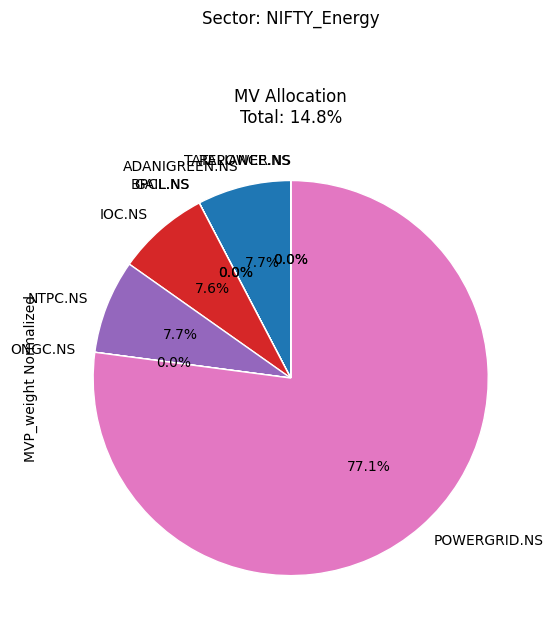

## NIFTY_Transportation

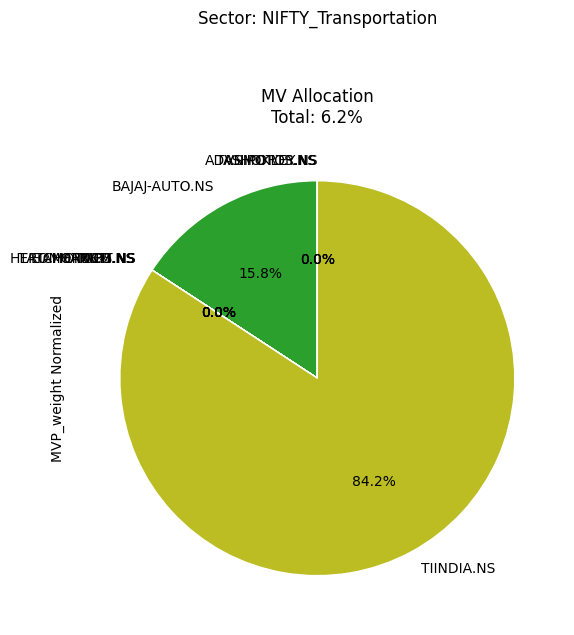

## NIFTY_Infrastructure

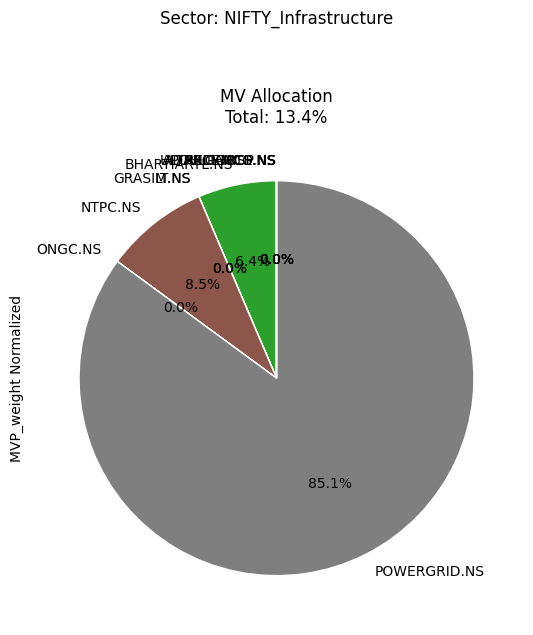

## NIFTY_MNC

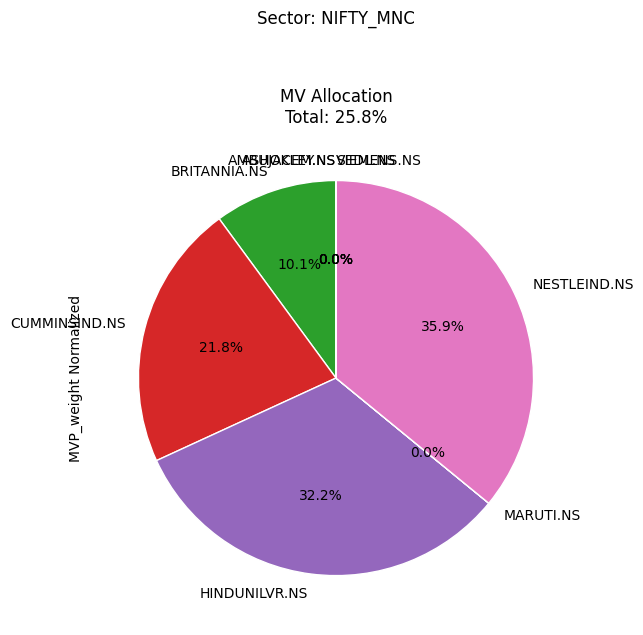

## NIFTY_Consumption

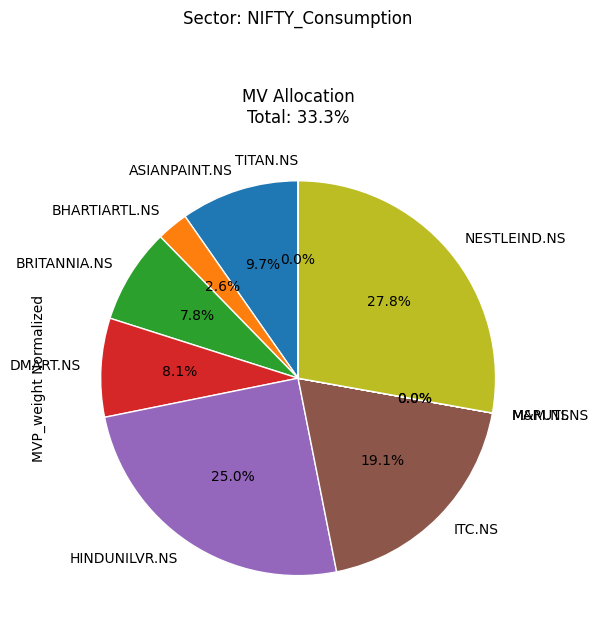

## NIFTY_Services

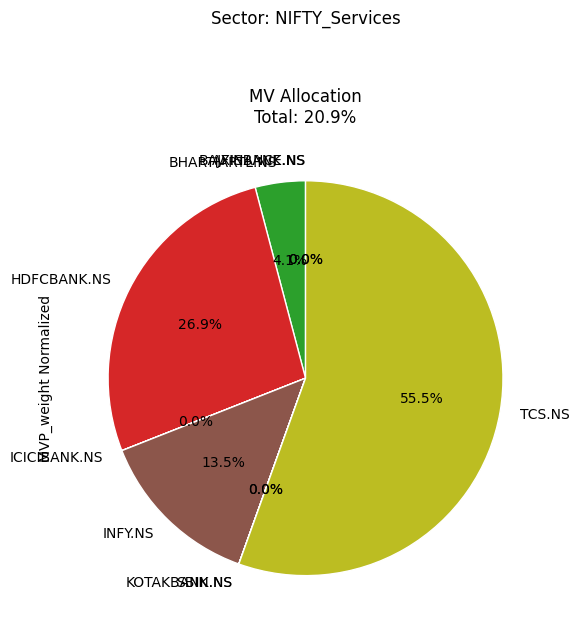

## NIFTY_100_ESG

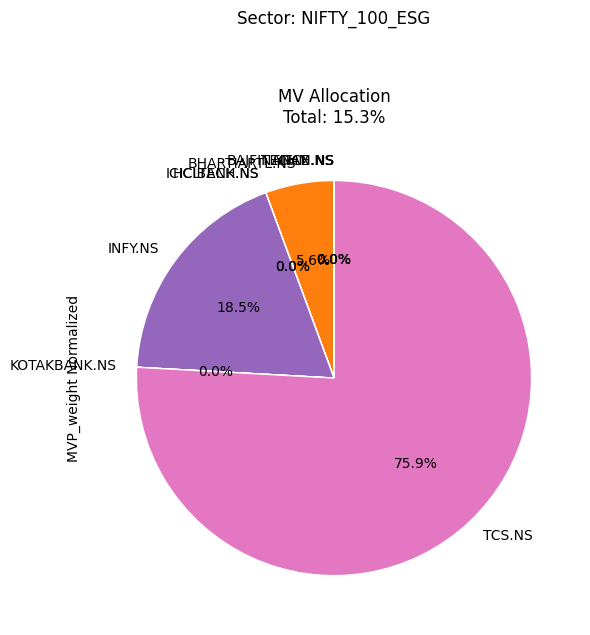

## NIFTY_Housing

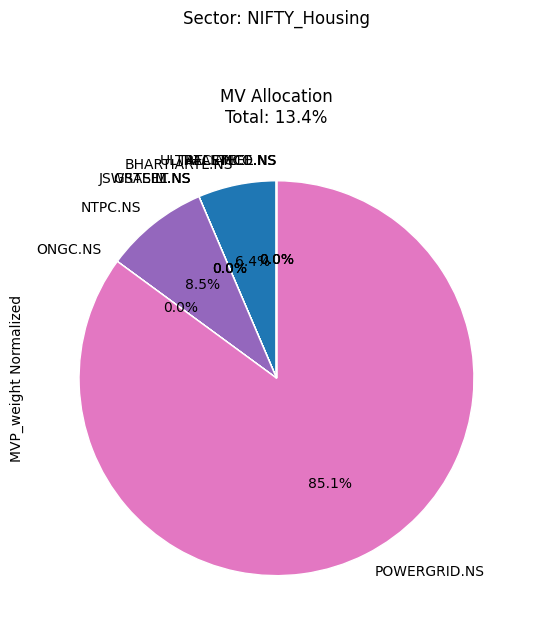

## NIFTY_Manufacturing

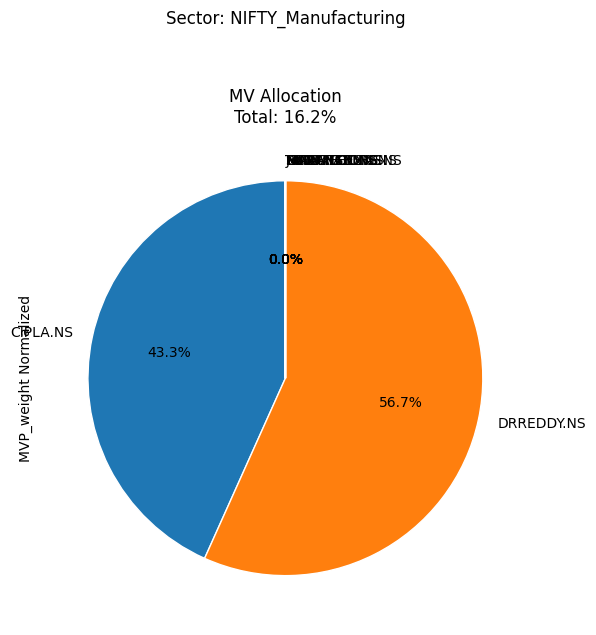

## NIFTY_Commodities

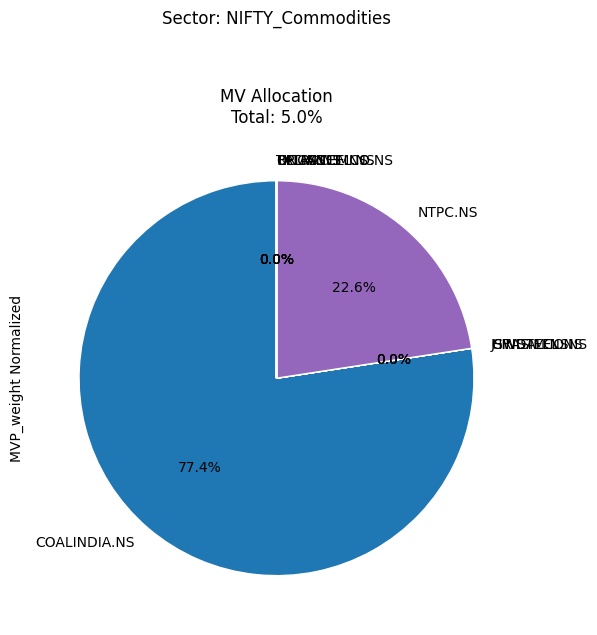

# Sector Cumulative Returns

## NIFTY_Energy

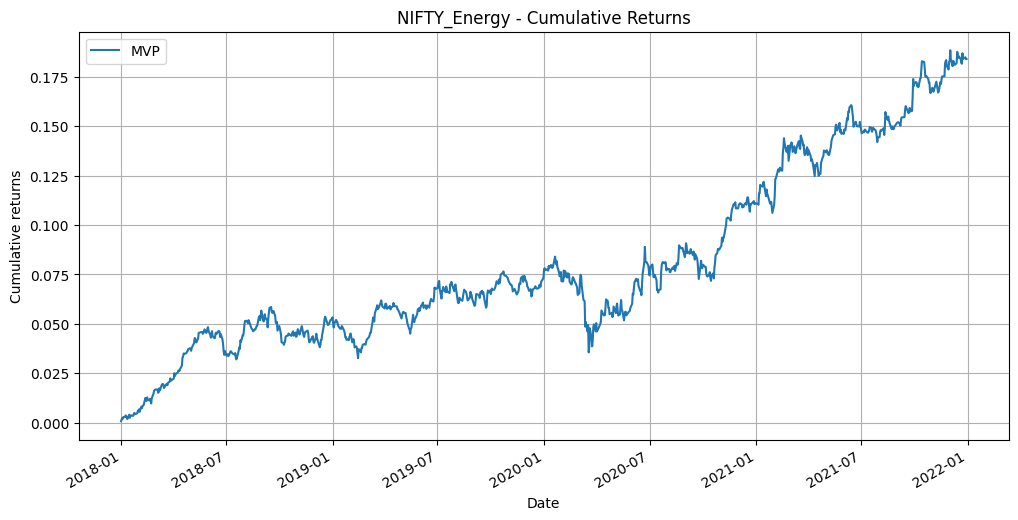

## NIFTY_Transportation

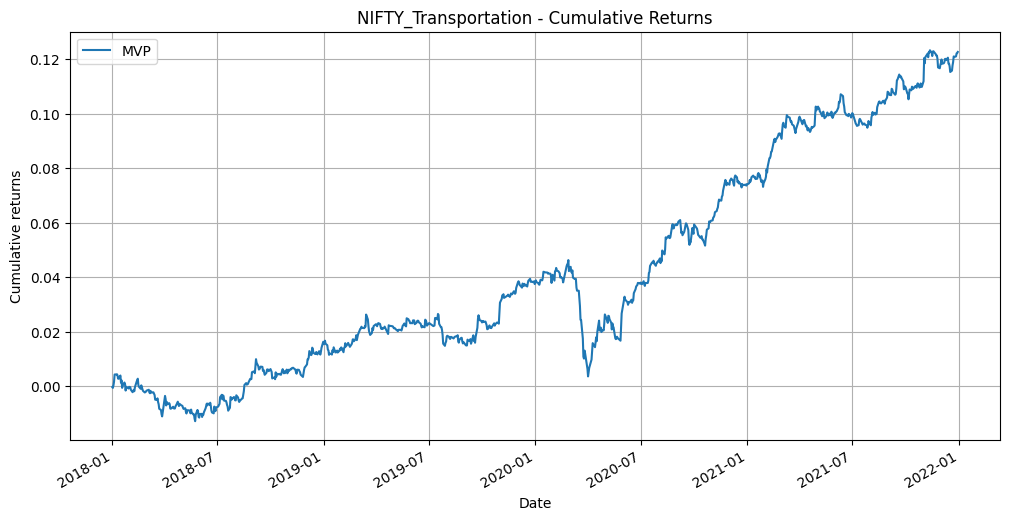

## NIFTY_Infrastructure

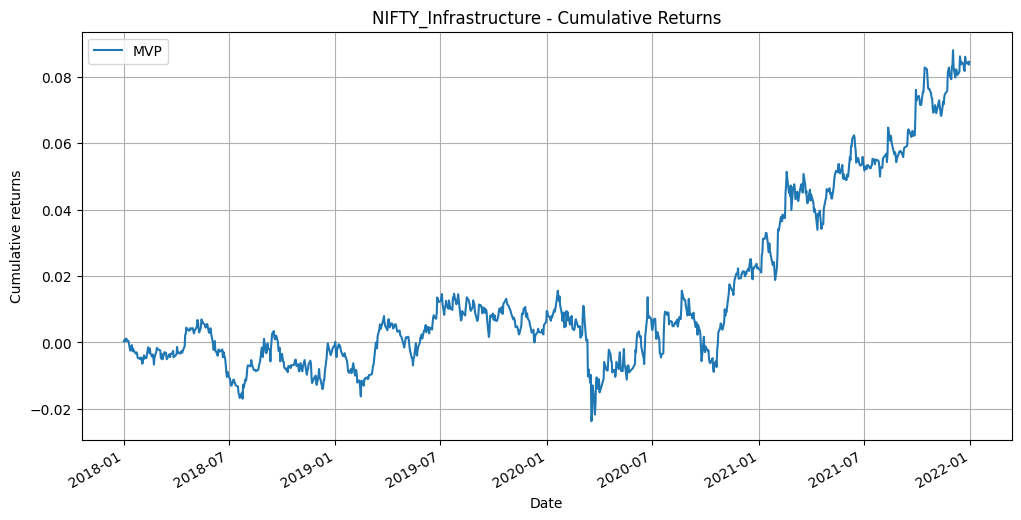

## NIFTY_MNC

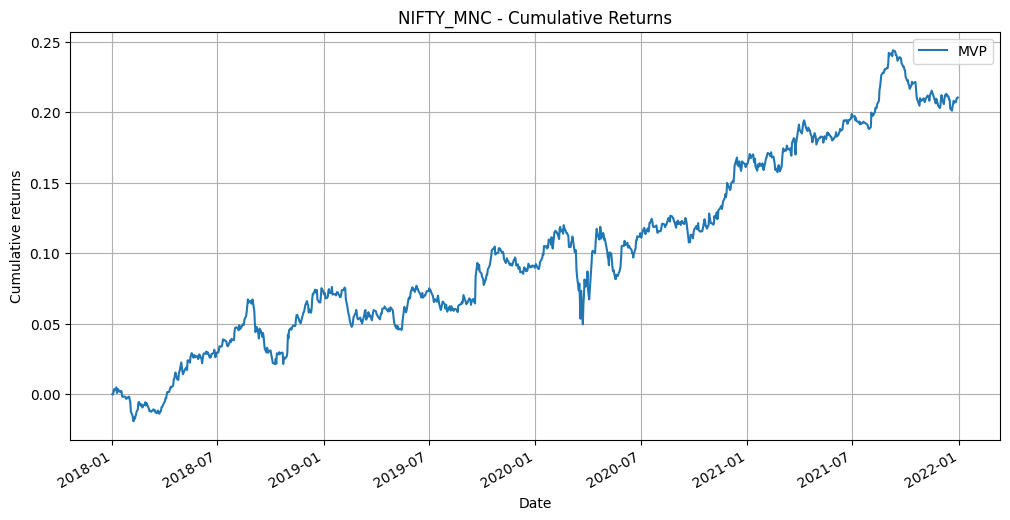

## NIFTY_Consumption

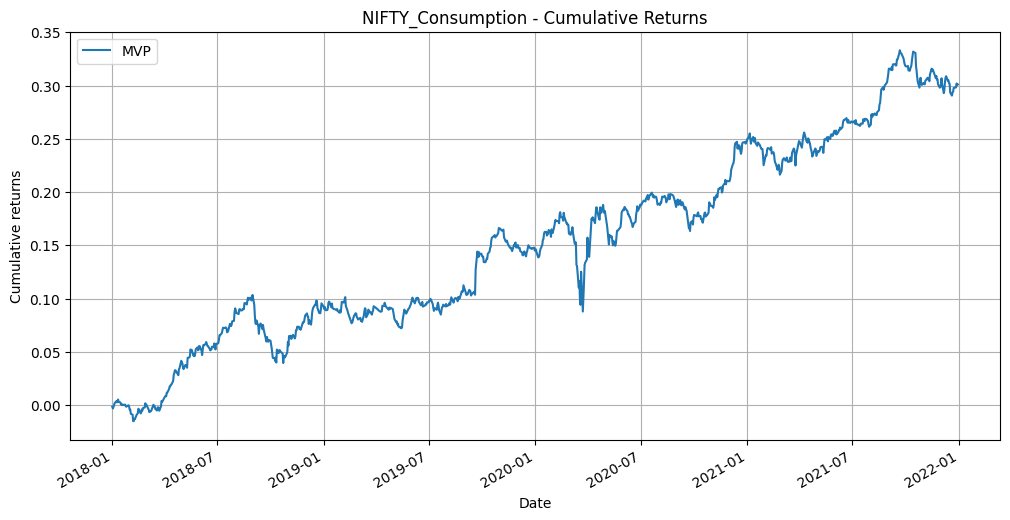

## NIFTY_Services

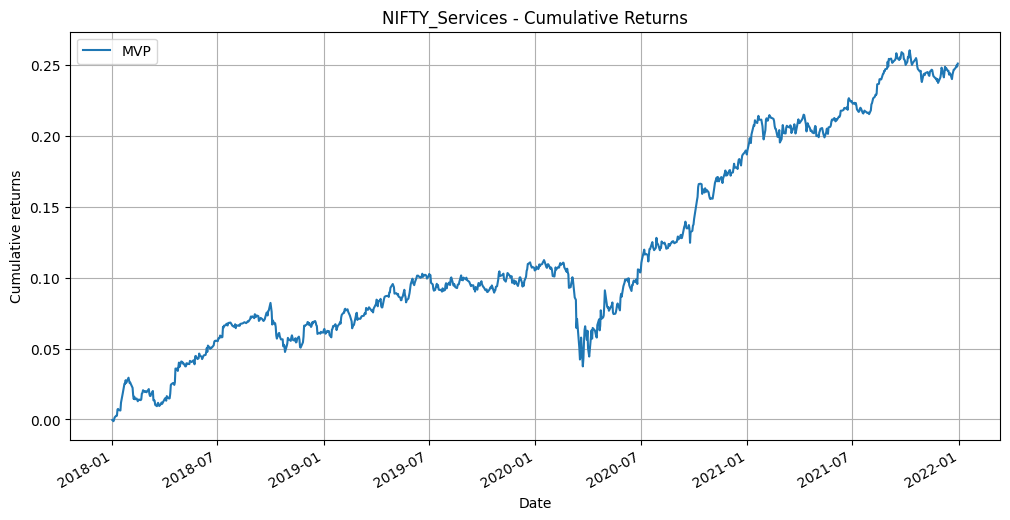

## NIFTY_100_ESG

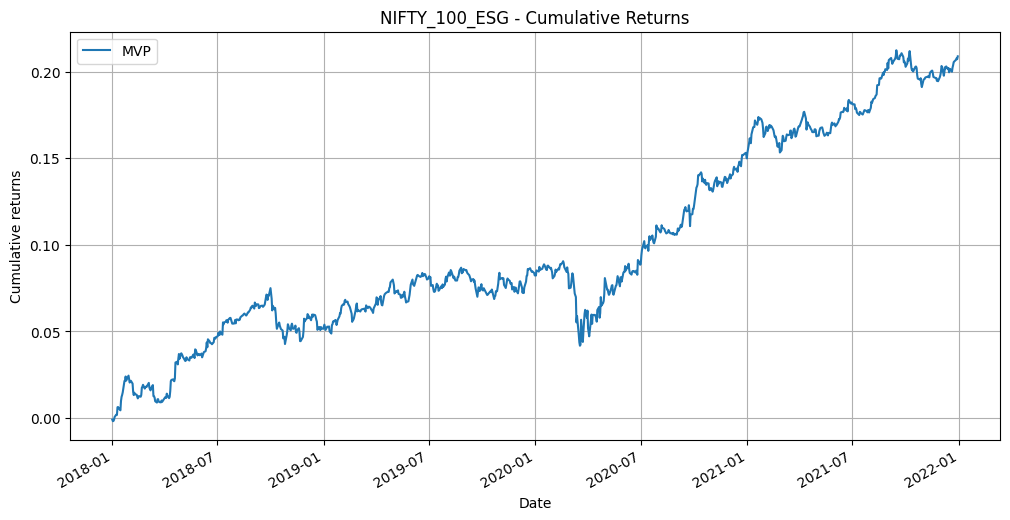

## NIFTY_Housing

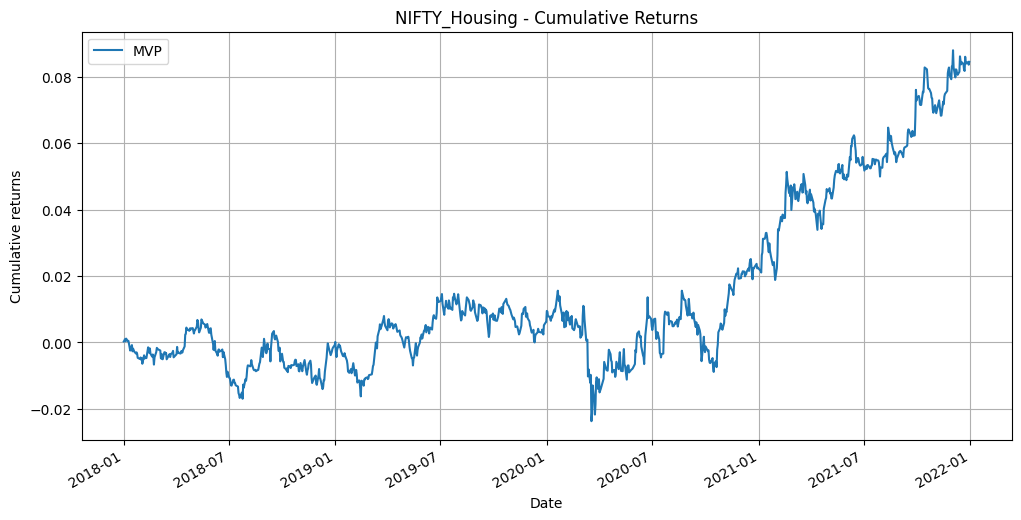

## NIFTY_Manufacturing

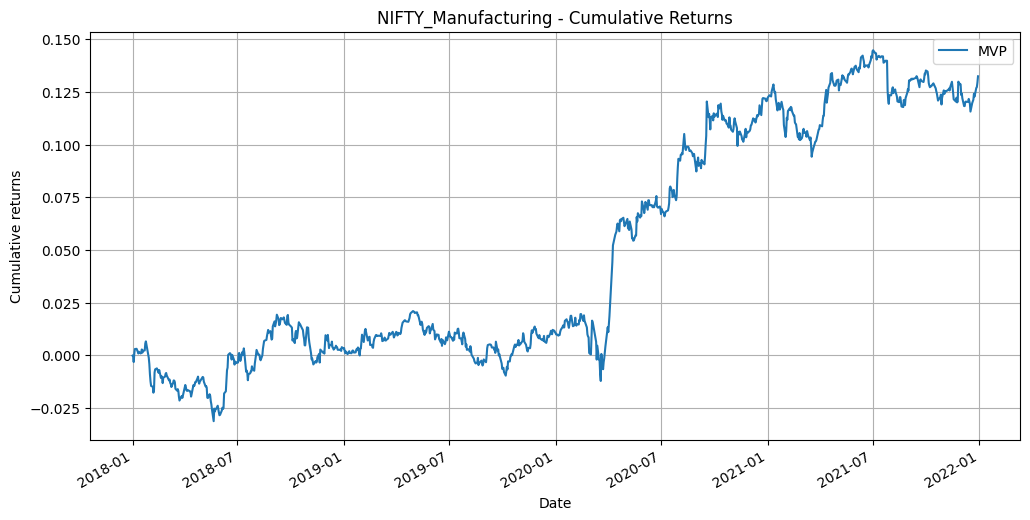

## NIFTY_Commodities

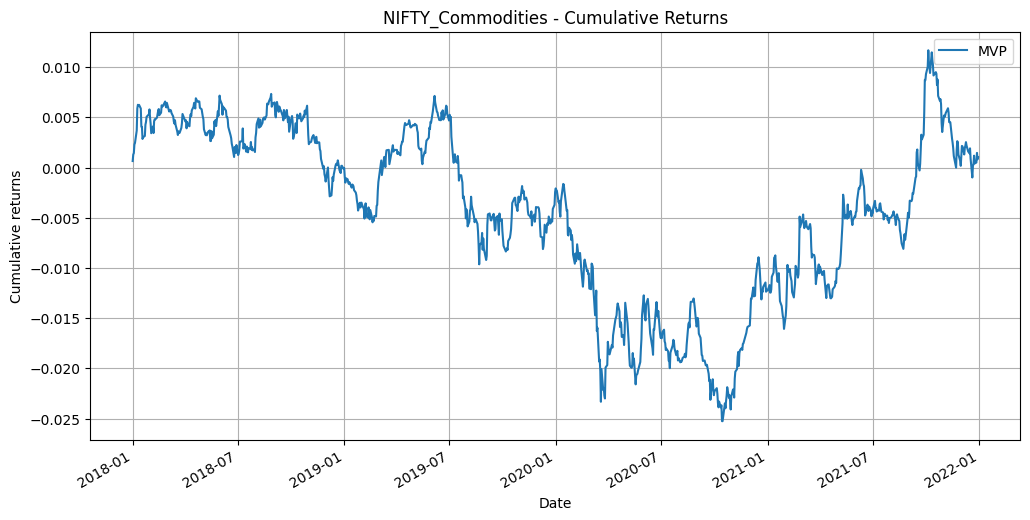

# Overall Portfolio Performance

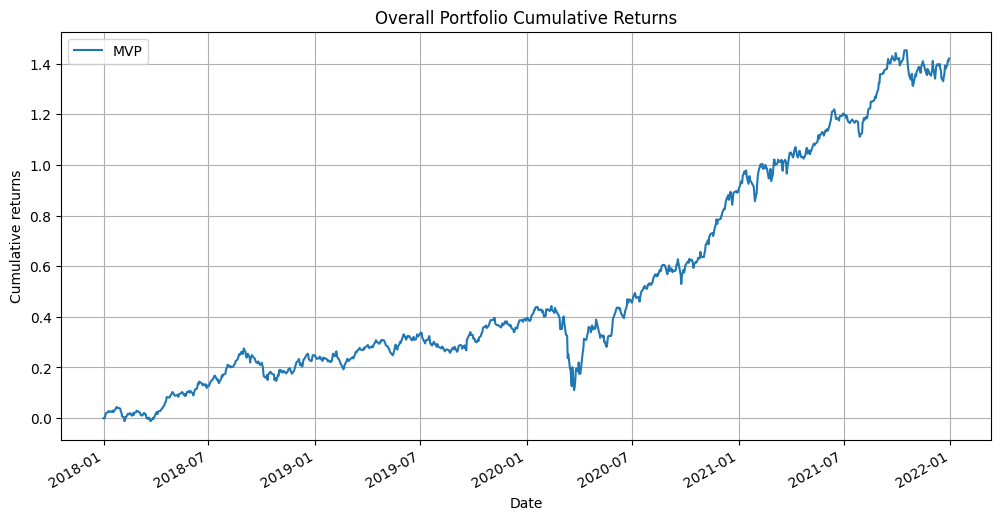

In [37]:
display(Markdown("# Sector Weight Tables"))
generate_sector_tables(weight_df)

display(Markdown("# Portfolio Performance Metrics"))
performance_styled = save_table(performance_df, 'Portfolio Performance by Sector', 'sector_performance')
display(performance_styled)
display(FileLink('sector_performance.xlsx', result_html_prefix="Download Excel Table: "))

display(Markdown("# Sector Allocations"))
for sector in weight_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_visualizations(sector)

display(Markdown("# Sector Cumulative Returns"))
for sector in weight_df['Sector'].unique():
    display(Markdown(f"## {sector}"))
    plot_sector_cumulative_returns(sector)

display(Markdown("# Overall Portfolio Performance"))
plt.figure(figsize=(12, 6))
((1 + (Y_assets @ w_mvp)).cumprod()-1).plot(label='MVP')
plt.title('Overall Portfolio Cumulative Returns')
plt.ylabel('Cumulative returns')
plt.legend()
plt.grid(True)
plt.savefig('overall_cumulative_returns.png', bbox_inches='tight')
plt.show()
